# Udacity Self-Driving Car Nanodegree
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

**PS: It is completed by traditional Computer Vision instead of Deep Learning.**

## 1. Camera calibration

* `cv2.findChessboardCorners` and `cv2.calibrateCamera` are used to get calibration matrix. 
* This matrix makes distorted images to be undistorted.

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Camera calibration
def camera_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # image size
    img_size = None

    # Make a list of calibration images
    chessboard_images = glob.glob('./camera_cal/calibration*.jpg')

    for image in chessboard_images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_size = gray.shape[::-1]

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

    # mtx: Camera matrix
    # dist: Distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    print(mtx)
    print(dist)
    pickle.dump(dist_pickle, open('calibration.p', 'wb'))
    

# Distortion correction
def cal_undistort(img):
    # undistortion on the original image instead of gray-scaled image
    data = pickle.load(open('calibration.p', 'rb'))
    mtx, dist = data['mtx'], data['dist']
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Apply the distortion correction to a road image

[[1.15694047e+03 0.00000000e+00 6.65948821e+02]
 [0.00000000e+00 1.15213880e+03 3.88784788e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-2.37638059e-01 -8.54041626e-02 -7.90999654e-04 -1.15882223e-04
   1.05725968e-01]]


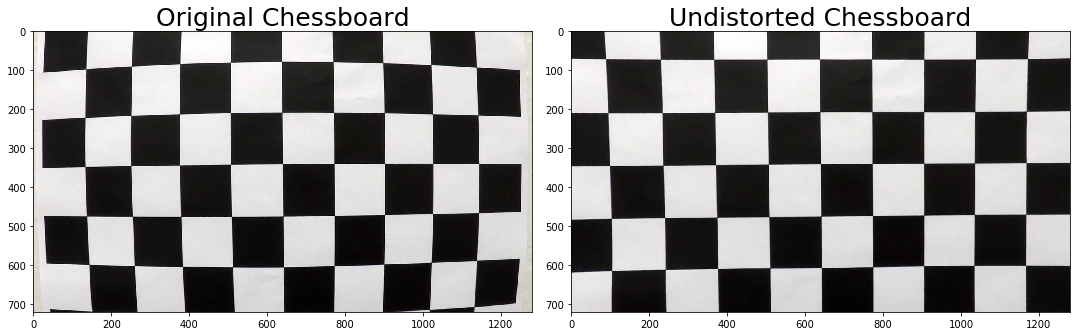

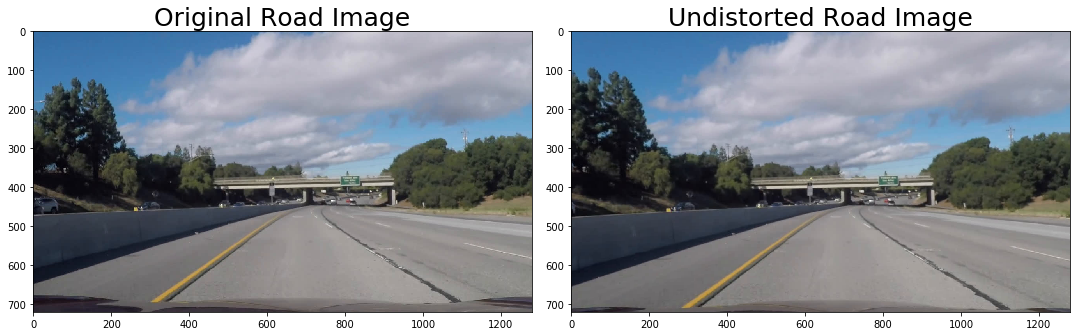

In [3]:
'''Visualization'''

camera_calibration()
# undistort chessboard image
cb_img = mpimg.imread('./camera_cal/calibration01.jpg')
undistorted_chessboard = cal_undistort(cb_img)

# undistort road image
road_img = mpimg.imread('./test_images/challenge02.jpg')
undistorted_road_img = cal_undistort(road_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
f.tight_layout()
ax1.imshow(cb_img)
ax1.set_title('Original Chessboard', fontsize=25)
ax2.imshow(undistorted_chessboard)
ax2.set_title('Undistorted Chessboard', fontsize=25)
plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.)
# plt.savefig("output_images/undistorted_chessboard.jpg",bbox_inches='tight')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
f.tight_layout()
ax1.imshow(road_img)
ax1.set_title('Original Road Image', fontsize=25)
ax2.imshow(undistorted_road_img)
ax2.set_title('Undistorted Road Image', fontsize=25)
plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.)
# plt.savefig("output_images/undistorted_road.jpg",bbox_inches='tight')

## 2. Image thresholding

1. Image thresholding includes Extraction of l_channel from HLS color space and b_channel from LAB color space.
2. Direction thresholding is also combined after color thresholding to highlight the lane lines from horizontal.

Updated: direction thresholding is removed due to lack of performance.

In [4]:
# Image thresholding
def image_thresh(img, l_thresh=(180 , 255), b_thresh=(185, 255)):
    new_img = np.copy(img)

    # 1) Convert to HLS color space
    hls = cv2.cvtColor(new_img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    l_channel = l_channel * (255 / np.max(l_channel))
    # 2) Apply a threshold to the L channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    # 3) Convert to LAB color space
    lab = cv2.cvtColor(new_img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:, :, 2]
    # don't normalize if there are no yellows in the image
    if np.max(b_channel) > 175:
        b_channel = b_channel * (255 / np.max(b_channel))
    # 4) Apply a threshold to the B channel
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > b_thresh[0]) & (b_channel <= b_thresh[1])] = 1

    # 5) Apply a Sobel x to the x
    sobelx = cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 1, 0)  # Take the derivative in x at b_channel
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    sobely = cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 0, 1)
    abs_sobely = np.absolute(sobely)  # Absolute x derivative to accentuate lines away from horizontal


    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad > 0) & (dir_grad <= 0.1)] = 1

    # scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    # sx_binary = np.zeros_like(scaled_sobel)
    # sx_binary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    # combined_binary[(l_binary == 1) | (b_binary == 1) | (dir_binary == 1)] = 1

    return combined_binary

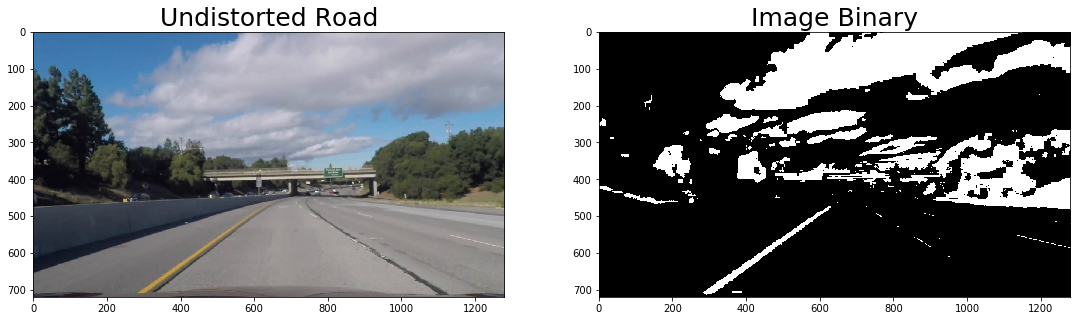

In [5]:
'''Visualization'''
image_binary = image_thresh(undistorted_road_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.imshow(undistorted_road_img)
ax1.set_title('Undistorted Road', fontsize=25)
ax2.imshow(image_binary, cmap='gray')
ax2.set_title('Image Binary', fontsize=25)
plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.)

plt.savefig("output_images/image_binary.jpg",bbox_inches='tight')

## 3. Perspective Transform

Compute the perspective transform using source and destination points:
* M = `cv2.getPerspectiveTransform(src, dst)`             # perspective matrix 
* Minv = `cv2.getPerspectiveTransform(dst, src)`          # inverse perspective matrix
* warped = `cv2.warpPerspective(img, M, img_size)`        # "birds-eye" view after transform

In [6]:
# Perspective transform
def perspective_tansform(img):
    '''
    src = np.float32([[,],[,],[,],[,]]) as four of the detected corners
    dst = np.float32([[,],[,],[,],[,]]) as destination points after transformation
    shape = [720, 1280]

    w = img_size[0] = img.shape[1]
    h = img_size[1] = img.shape[0]
    img_size = (h, w)
    '''

    h, w = img.shape[:2]
    img_size = (w, h)

    src = np.float32([[575, 460], [710, 460], [260, h-40], [1050, h-40]])
    offset = 450
    dst = np.float32([[offset, 0], [w-offset, 0], [offset, h], [w-offset, h]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

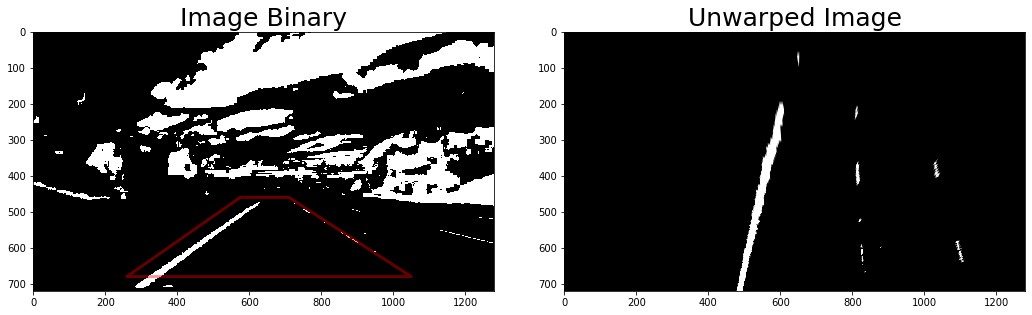

In [8]:
'''Visualization'''
unwarped_road, M, Minv = perspective_tansform(image_binary)
img_size = (unwarped_road.shape[1], unwarped_road.shape[0])
h, w = img_size[1], img_size[0]

'''Unwarped road'''
src = np.float32([[575, 460], [710, 460], [260, h-40], [1050, h-40]])
offset = 450
dst = np.float32([[offset, 0], [w-offset, 0], [offset, h], [w-offset, h]])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(image_binary, cmap='gray')
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Image Binary', fontsize=25)
ax2.imshow(unwarped_road, cmap='gray')
ax2.set_title('Unwarped Image', fontsize=25)
plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.)
# plt.savefig("output_images/bird-eye_image.jpg",bbox_inches='tight')

In [9]:
M, Minv

(array([[-3.07805596e-01, -1.52595729e+00,  8.29720177e+02],
        [-4.21884749e-15, -2.09425626e+00,  9.63357879e+02],
        [-7.10152423e-18, -2.41163476e-03,  1.00000000e+00]]),
 array([[ 3.55263158e-01, -7.36902250e-01,  4.15131579e+02],
        [ 3.99680289e-15, -4.77496484e-01,  4.60000000e+02],
        [ 2.60208521e-18, -1.15154712e-03,  1.00000000e+00]]))

## 4. Detect lane lines

From unwarped (bird eye's view) image, Left/Right polynomial function and radius of curvature are calculated.

The steps for finding lane lines are as follow:
1. Make **histogram** of bottom half of image.
2. Find the **peak** of the left and right halves of the histogram.
    They are starting point for the left and right lines.
3. Do `sliding_window_polyfit` from 0 to image height.
   Once the lines are detected and fitted, the step of sliding windows can be skipped using `prev_fit_polyfit`. 
4. **Fit** the result points with a second order polynomial.
5. Calcualte the radius of curvatures with `radius_curvature` and cross track error using conversions in x and y from pixels space to meters.
6. Draw the result on unwarped image.
7. **Warp** the result image using inverse perspective transform `Minv`.

**PS**: *In video processing, It is not needed to search all the intervals, the algorithm **remembers the line position in the previous frame** and search only near that line position. With this method, the calculation time can be greatly improved.*

### 4.1 Sliding Window to find the lane pixels
1. Define 10 windows, the window's height is the height of image divide the number of windows.
2. Loop through those windows:
    * Identify window boundaries in x and y (and right and left).
    * Identify the nonzero pixels in the image and their index.
    * Identify the nonzero pixels in x and y within the window and append its index to each line.
    * If we found > minpix pixels, recenter next window, the new center is the mean of pixels positions.
3. Extract left and right line pixel positions.

**PS**: Once the lines are detected and fitted, the step of sliding windows can be skipped.

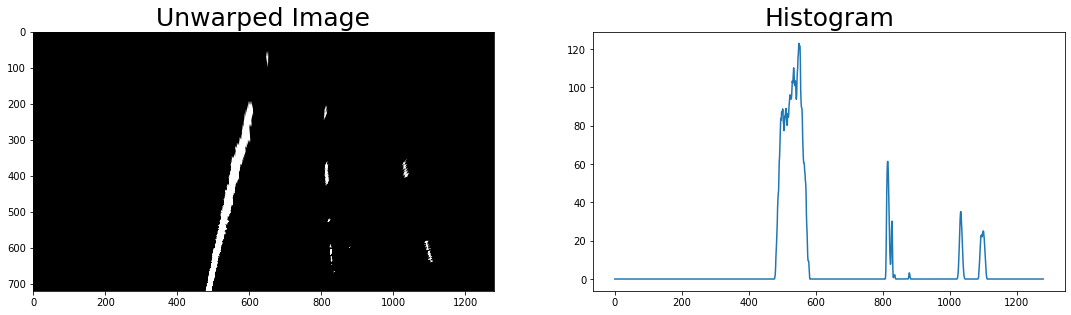

In [10]:
'''Histogram'''
img_size = (unwarped_road.shape[1], unwarped_road.shape[0])
h, w = img_size[1], img_size[0]

hist = np.sum(unwarped_road[unwarped_road.shape[0]//2:,:], axis=0)
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16,4))
ax1.imshow(unwarped_road, cmap='gray')
ax1.set_title('Unwarped Image', fontsize=25)
ax2.plot(hist)
ax2.set_title('Histogram', fontsize=25)
plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.)
# plt.savefig("output_images/histogram.jpg",bbox_inches='tight')

In [11]:
def sliding_window_polyfit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)  # 直方图的中点

    # Previously the left/right base was the max of the left/right half of the histogram
    # This changes it so that only a quarter of the histogram (directly to the left/right) is considered
    quarter_point = np.int(midpoint//2)

    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point  # 左1/4~2/4半部分最大值坐标
    rightx_base = np.argmax(histogram[midpoint:(midpoint + quarter_point)]) + midpoint  # 右3/4~4/4半部分最大值坐标

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()  # np.nonzero函数是numpy中用于得到数组array中非零元素的位置（数组索引）的函数
    # nonzeroy.shape = nonzerox.shape = 1280*760
    nonzeroy = np.array(nonzero[0])  # 非0元素的y索引，其实就是坐标
    nonzerox = np.array(nonzero[1])  # 非0元素的x索引，其实就是坐标

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height

        ### Find the four below boundaries of the window ###
        ### 绘制一个矩形，用直方图最大值向两侧偏离margin
        ### Gonna be updated
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Store the rectangular windows in the list for visualization later
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        ### 在对于包围框中的元素，取其x坐标
        ### nonzeroy是一个一维向量,长度为1280*760，存放图中所有像素点的y坐标，x坐标同理
        ### 下面面的操作首先进行逻辑运算筛选符合条件的索引，符合条件的为True，否则为False
        ### 然后用nonzero把所有True的点的索引取出来，也就是说在nonzeroy中满足条件的点的索引
        ### 用该索引取nonzeroy的值，得到的就是该点的y坐标
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        ## 遍历10个窗口，如果窗口内的像素点个数超过了minpix，就把窗口的中心点移至这些像素点的中心点
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))  # 索引取nonzeroy的值，得到的就是该点的x坐标
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    # eg: left_lane_inds 是包含一组列表的列表，concatenate将它们合成一个列表
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each using `np.polyfit`
    # 拟合车道线的曲线(二项式曲线)
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data

### 4.2 Previous polynomial to find the lane pixels
1. `prev_fit_polyfit` function performs basically the same task, but efficiently reduce difficulty of the search process by leveraging a previous fit (from a previous video frame, for example) and only searching for lane pixels within a certain range of that fit. 
2. Once the lines where there were fitted has been found, in the **next frame** of video, it is not necessary to do a blind search again. Instead, **search in a margin** around the **previous line position** can be used to find the lane lines.

In [12]:
def prev_fit_polyfit(binary_warped, left_fit_prev, right_fit_prev):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()  # np.nonzero函数是numpy中用于得到数组array中非零元素的位置（数组索引）的函数
    # nonzeroy.shape = nonzerox.shape = 1280*760
    nonzeroy = np.array(nonzero[0])  # 非0元素的y索引，其实就是坐标
    nonzerox = np.array(nonzero[1])  # 非0元素的x索引，其实就是坐标
    margin = 80

    left_lane_inds = ((nonzerox > (
                left_fit_prev[0] * (nonzeroy ** 2) + left_fit_prev[1] * nonzeroy + left_fit_prev[2] - margin)) &
                      (nonzerox < (left_fit_prev[0] * (nonzeroy ** 2) + left_fit_prev[1] * nonzeroy + left_fit_prev[
                          2] + margin)))
    right_lane_inds = ((nonzerox > (
                right_fit_prev[0] * (nonzeroy ** 2) + right_fit_prev[1] * nonzeroy + right_fit_prev[2] - margin)) &
                       (nonzerox < (right_fit_prev[0] * (nonzeroy ** 2) + right_fit_prev[1] * nonzeroy + right_fit_prev[
                           2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)

    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [13]:
'''Sliding Windows'''
margin = 80
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data = sliding_window_polyfit(unwarped_road)

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((unwarped_road, unwarped_road, unwarped_road))*255)

# Generate x and y values for plotting
ploty = np.linspace(0, unwarped_road.shape[0]-1, unwarped_road.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Draw the windows on the visualization image
for rect in rectangle_data:
    cv2.rectangle(out_img, (rect[2], rect[0]), (rect[3], rect[1]), (0, 0, 255), 4)
    cv2.rectangle(out_img, (rect[4], rect[0]), (rect[5], rect[1]), (0, 0, 255), 4)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = unwarped_road.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

In [14]:
'''Previous Polynomials'''
# Create an image to draw on and an image to show the selection window
left_fit_new, right_fit_new, left_lane_inds2, right_lane_inds2 = prev_fit_polyfit(unwarped_road, left_fit, right_fit)
left_fitx_new = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx_new = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

out_img2 = np.uint8(np.dstack((unwarped_road, unwarped_road, unwarped_road)) * 255)
window_img = np.zeros_like(out_img2)

# Color in left and right line pixels
nonzero = unwarped_road.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img2[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img2[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]


# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
# Set the width of the windows +/- margin
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane regions onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)

Text(0.5, 1.0, 'Prev Poly')

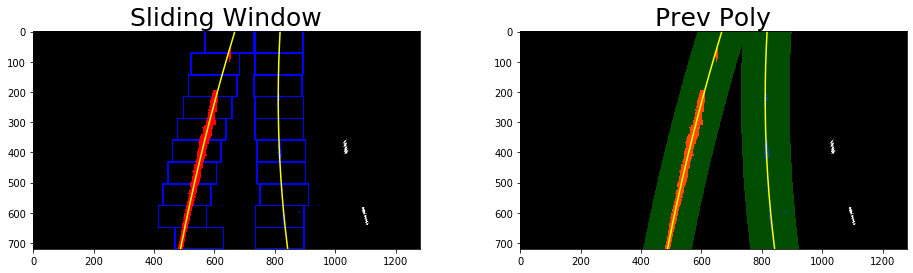

In [15]:
'''Visualization'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.imshow(out_img)
plt.sca(ax1)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
ax1.set_title('Sliding Window', fontsize=25)

ax2.imshow(result, cmap='gray')
plt.sca(ax2)
plt.plot(left_fitx_new, ploty, color='yellow')
plt.plot(right_fitx_new, ploty, color='yellow')
ax2.set_title('Prev Poly', fontsize=25)
# plt.savefig("output_images/find_lane_lines.jpg",bbox_inches='tight')

### 4.3 Radius of curvature of the lane
1. Determine the meters per pixel in y/x dimension.
2. Fit new polynomials to x,y in real world space.
3. Calculate the new radius of curvature which is in meters.
4. Calculate the position of the vehicle based on the center of the lane.

In [16]:
def radius_curvature(binary_warped, l_fit, r_fit, l_lane_inds, r_lane_inds):
    img_shape = binary_warped.shape
    left_curverad, right_curverad, center_bias = (0, 0, 0)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension 车道线间距3.7m

    h = img_shape[0]
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])  # cover same y-range as image
    y_eval = np.max(ploty)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds]
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]

    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * left_fit_cr[0])
        right_curverad = ((1 + (
                    2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * right_fit_cr[0])
        # Now our radius of curvature is in meters

    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts
    if r_fit is not None and l_fit is not None:
        car_position = img_shape[1] / 2
        l_fit_x_int = l_fit[0] * h ** 2 + l_fit[1] * h + l_fit[2]
        r_fit_x_int = r_fit[0] * h ** 2 + r_fit[1] * h + r_fit[2]
        center_position = (r_fit_x_int + l_fit_x_int) / 2
        center_bias = (car_position - center_position) * xm_per_pix

    return left_curverad, right_curverad, center_bias

In [17]:
left_cur, right_cur, ctb = radius_curvature(unwarped_road, left_fit_new, right_fit_new, left_lane_inds2, right_lane_inds2)
print('radius of curvature: %.3f m, %.3fm' % (left_cur, right_cur))
print('radius of curvature: %.3f m' % ((left_cur + right_cur)/2))
print('center: %.3f m' % (ctb))

radius of curvature: 2186.001 m, 1305.509m
radius of curvature: 1745.755 m
center: -0.133 m


## 5. Drawing on the image

1. Until now, we have:
 * an original road image called `road_img`
 * an unwarped binary image called `unwarped_road`
 * fitted lane lines with a polynomial `left_fit`, `right_fit` representing the x and y pixel values of the lines.

2. Define a function `draw_lane` to project those lines onto the original image as a selected region.
 
3. Define a function `draw_data` to write text (radius of curvature, center bias) on the image.

In [18]:
# Draw the lane region on the original image
def draw_lane(original_img, binary_warped, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    warped_region = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    # Mask the region between left_fitx(left lane) and right_fitx(right lane) showing the driving area
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = l_fit[0] * ploty ** 2 + l_fit[1] * ploty + l_fit[2]
    right_fitx = r_fit[0] * ploty ** 2 + r_fit[1] * ploty + r_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warped_region, np.int_([pts]), (0, 255, 0))
    cv2.polylines(warped_region, np.int32([pts_left]), isClosed=False, color=(255, 0, 0), thickness=10)
    cv2.polylines(warped_region, np.int32([pts_right]), isClosed=False, color=(255, 0, 0), thickness=10)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    # Transform to the real world
    unwarped_region = cv2.warpPerspective(warped_region, Minv, (binary_warped.shape[1], binary_warped.shape[0]))
    # Combine the result with the original image
    drawed = cv2.addWeighted(new_img, 1, unwarped_region, 0.3, 0)

    return drawed

# Write the text indicating radius of curvature
def draw_data(drawed_img, curv_rad, center_bias):
    new_img = np.copy(drawed_img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of curvature is: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (50, 70), font, 1.5, (200, 255, 255), 2, cv2.LINE_AA)
    direction = ''
    if center_bias >= 0:
        direction = 'right'
    elif center_bias < 0:
        direction = 'left'
    abs_center_bias = abs(center_bias)
    text = '{:.2f}'.format(abs_center_bias) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (50, 120), font, 1.5, (200, 255, 255), 2, cv2.LINE_AA)

    return new_img

### 5.1 Extract the lane regions both in warped and unwarped road image

Text(0.5, 1.0, 'Warped Region')

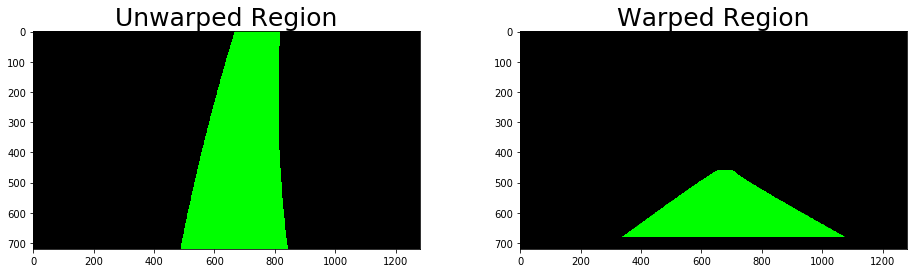

In [19]:
'''Warped region'''
# Create an image to draw the lines on
warp_zero = np.zeros_like(unwarped_road).astype(np.uint8)
unwarped_region = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
# Mask the region between left_fitx(left lane) and right_fitx(right lane) showing the driving area
pty = np.linspace(0, unwarped_road.shape[0]-1, unwarped_road.shape[0] )
pts_l = np.array([np.transpose(np.vstack([left_fitx, pty]))])
pts_r = np.array([np.flipud(np.transpose(np.vstack([right_fitx, pty])))])
ptslr = np.hstack((pts_l, pts_r))

# Draw the lane onto the warped blank image
cv2.fillPoly(unwarped_region, np.int_([ptslr]), (0, 255, 0))

'''Unwarped region (Real world)'''
# Warp the blank back to original image space using inverse perspective matrix (Minv)
# Transform to the real world
warped_region = cv2.warpPerspective(unwarped_region, Minv, (warp_zero.shape[1], warp_zero.shape[0]))

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16,4))
ax1.imshow(unwarped_region)
ax1.set_title('Unwarped Region', fontsize=25)
ax2.imshow(warped_region)
ax2.set_title('Warped Region', fontsize=25)
# plt.savefig("output_images/region_of_lane.jpg",bbox_inches='tight')

### 5.2 Draw the detected lane back onto the original Image

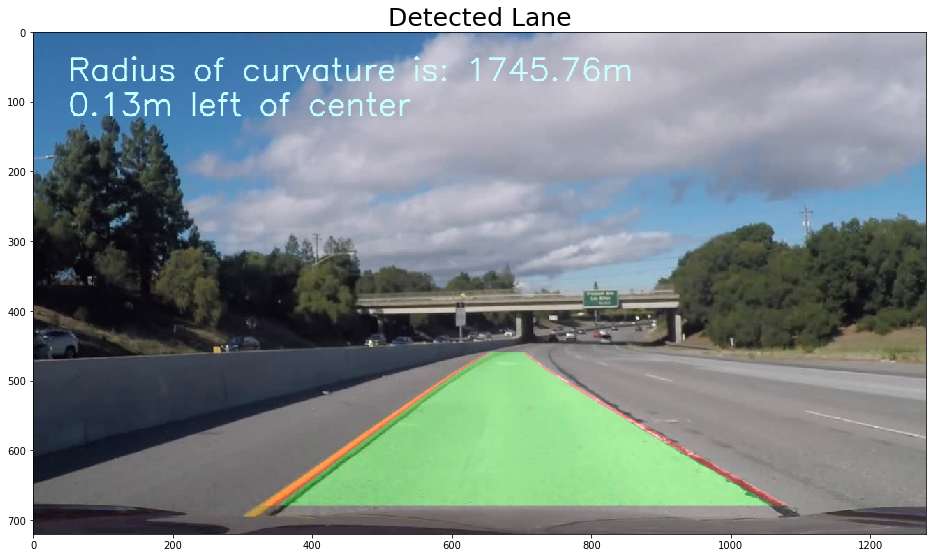

In [20]:
'''Draw onto the original image'''
drawed_img = draw_lane(road_img, unwarped_road, left_fit, right_fit, Minv)
rad_l, rad_r, center_bias = radius_curvature(unwarped_road, left_fit, right_fit, left_lane_inds, right_lane_inds)
detected_lane = draw_data(drawed_img, (rad_l + rad_r)/2, center_bias)

plt.figure(figsize=(16,10))
plt.title("Detected Lane", fontsize=25)
plt.imshow(detected_lane)
# plt.savefig("output_images/detected_lane.jpg",bbox_inches='tight')

## 6. Video processing

* Define a image-processing pipeline including `Camera calibration`, `Image thresholding`, `Perspective Transform`, `Detect lane lines`, `Drawing`.
* Apply the pipeline to the given video.

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### 6.1 Define a pipeline `image_process` 
to integrate all needed functions to process images and then applied in video frames.

In [22]:
def image_process(img):
    new_img = np.copy(img)
    # ----------------------------------------
    # Image Undistortion
    # ----------------------------------------
    undistort = cal_undistort(new_img)

    # ----------------------------------------
    # Image Thresholding
    # ----------------------------------------
    img_binary = image_thresh(undistort, l_thresh=(180, 255), b_thresh=(185,255))

    # ----------------------------------------
    # Perspective Transform
    # ----------------------------------------
    unwarped, _, Minv = perspective_tansform(img_binary)

    # ----------------------------------------
    # Lane Lines Finding
    # ----------------------------------------
    # if both left and right lines were detected last frame, `polyfit_using_prev_fit` is going to be applied
    # otherwise `sliding window` is selected
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(unwarped)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = prev_fit_polyfit(unwarped, l_line.best_fit, r_line.best_fit)

    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0] * h ** 2 + l_fit[1] * h + l_fit[2]
        r_fit_x_int = r_fit[0] * h ** 2 + r_fit[1] * h + r_fit[2]
        x_int_diff = abs(r_fit_x_int - l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None

    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)

    # ----------------------------------------
    # Drawing
    # ----------------------------------------
    # Draw the lane & Write text onto the warped blank image

    if l_line.best_fit is not None and r_line.best_fit is not None:
        # draw the current best fit if it exists
        drawed_img = draw_lane(new_img, unwarped, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = radius_curvature(unwarped, l_line.best_fit, r_line.best_fit,
                                                               l_lane_inds, r_lane_inds)
        result = draw_data(drawed_img, (rad_l + rad_r) / 2, d_center)
    else:
        result = new_img

    return result

### 6.2 Define a Line Class for Storing Data

In [23]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = []
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')
        # number of detected pixels
        self.px_count = None

    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        n = 9
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit - self.best_fit)
            if (self.diffs[0] > 0.001 or \
                self.diffs[1] > 1.0 or \
                self.diffs[2] > 100.) and \
                    len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > n:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit) - n:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit) - 1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [24]:
l_line = Line()
r_line = Line()

### 6.3 Test on a single image

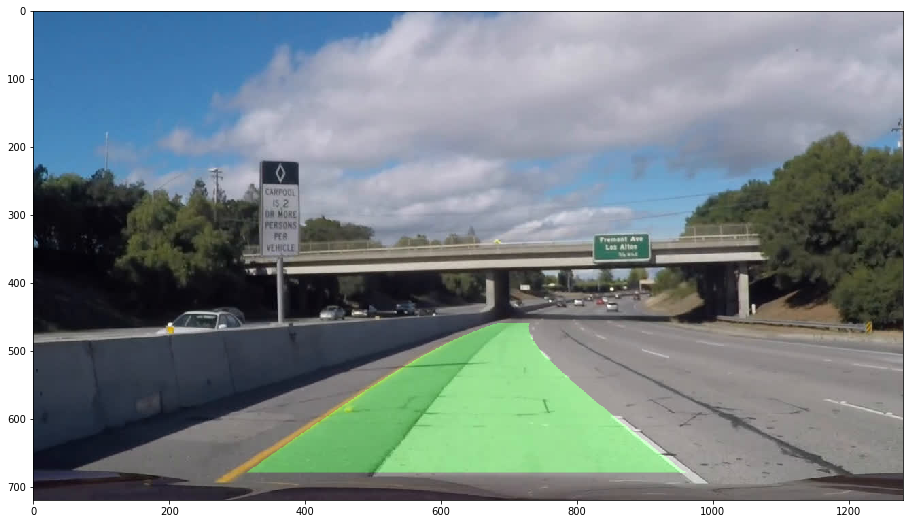

In [60]:
test_image = mpimg.imread('./test_images/challenge01.jpg')

result = image_process(test_image)
plt.figure(figsize=(16,9))
plt.imshow(result)

### 6.4 Test on the given video (project_video)

In [27]:
output = 'output_videos/project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(0,2)

clip1 = VideoFileClip('project_video.mp4')
output_clip = clip1.fl_image(image_process) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_output.mp4.
Moviepy - Writing video output_videos/project_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_output.mp4
CPU times: user 5min 19s, sys: 1min 21s, total: 6min 40s
Wall time: 4min 57s


In [28]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output))

### 6.5 Test on the given video (challenge_video)

In [30]:
challenge_output = "output_videos/challenge_output.mp4"
challenge_input = VideoFileClip("challenge_video.mp4")
video_process = challenge_input.fl_image(image_process) #NOTE: this function expects color images!!
video_process.write_videofile(challenge_output, audio=False)

t:   0%|          | 2/485 [00:00<00:45, 10.53it/s, now=None]

Moviepy - Building video output_videos/challenge_output.mp4.
Moviepy - Writing video output_videos/challenge_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_output.mp4


In [31]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(challenge_output))